In [149]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import time
from urllib.parse import urlparse, parse_qs
import math
import statistics
from pandasql import sqldf
import ast

In [150]:
df = pd.read_csv(r'Downloads/congress_stock_Transactions_cleaned.csv')

df['Performance'] = pd.to_numeric(df['Performance'].str.replace('%', ''), errors='coerce') / 100

df.head()

,Unnamed: 0,Ticker,StockName,StockType,TransactionType,TransactionAmount,PoliticianName,PoliticianDetails,Filed,Traded,Description,Performance,Transaction_Year,Filing_Delay,Trade_bucket,Filed_Adjusted
0,0,ITW,Illinois Tool Works Inc. Common Stock,Stock,Sale (Full),"[15001.0, 50000.0]",Tammy Duckworth,Senate / D,2023-05-01,2023-04-11,-,-0.0243,2023,20 days,Mid,2023-05-01
1,1,DIS,The Walt Disney Company,Stock,Sale (Full),"[1001.0, 15000.0]",Tammy Duckworth,Senate / D,2021-04-16,2021-04-05,-,-0.6906,2021,11 days,Low,2021-04-16
2,2,ITW,Illinois Tool Works Inc.,Stock,Sale (Partial),"[1001.0, 15000.0]",Tammy Duckworth,Senate / D,2021-04-16,2021-04-05,-,0.0087,2021,11 days,Low,2021-04-16
3,3,VZ,Verizon Communications Inc.,Stock,Sale (Full),"[15001.0, 50000.0]",Tammy Duckworth,Senate / D,2021-04-16,2021-04-05,-,-0.5292,2021,11 days,Mid,2021-04-16
4,4,GE,General Electric Company,Stock,Sale (Full),"[1001.0, 15000.0]",Tammy Duckworth,Senate / D,2018-10-26,2018-08-07,-,-0.4525,2018,80 days,Low,2018-10-26


# Questions to Answer
1. Which Senators are the most active
2. Which Senators are spending the most capital
3. Are senators who spend more and trade more more successfull? 
4. are senators outperforming the markets:: which ones
5. What stocks are the most popular 
6. How does this change every year
7. Is it better to follow all trades or copy specific people's Trades
8. what was the best purchse of 2023
9. Which senator made the worst trades in 2023

# Question 1: 
- Which Senators are the most active


In [207]:
# Question 1

senator_purchase_activity = df[df["TransactionType"] == "Purchase"].groupby(["PoliticianName", "Transaction_Year"]).agg(
    Transaction_Count = ("Ticker", "count")
).sort_values(by = ["Transaction_Year", "Transaction_Count"], ascending = [True, False])

senator_purchase_activity.head()

senator_purchase_activity = senator_purchase_activity.reset_index()

In [208]:
n = 100

top_senators_trades = pd.DataFrame()
top_n_per_year = []

#n = top_senators_trades["PoliticianName"].nunique()

unique_years = senator_purchase_activity["Transaction_Year"].unique()

for year in unique_years:
    # Get the top n senators for the year
    top_for_year = senator_purchase_activity[senator_purchase_activity["Transaction_Year"] == year].sort_values(by="Transaction_Count", ascending=False).head(n)
    
    # Assign ranks
    top_for_year['Rank'] = range(1, len(top_for_year) + 1)
    
    top_n_per_year.append(top_for_year)

# Concatenate all the DataFrames in the list
top_senators_trades = pd.concat(top_n_per_year, ignore_index=True)


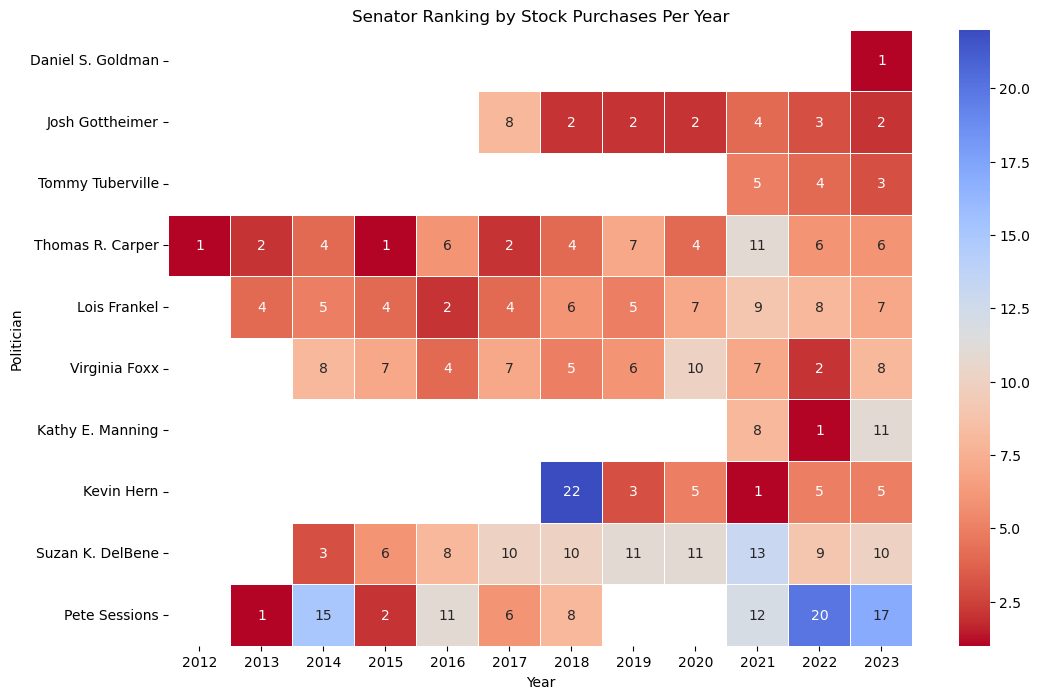

In [209]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

top_n = 10

# Creating a pivot table for the heatmap
top_senators_trades_pivot = top_senators_trades.pivot_table(index='PoliticianName', columns='Transaction_Year', values='Rank')


# Calculate the average rank for each politician
top_senators_trades_pivot['Average_Rank'] = top_senators_trades_pivot.mean(axis=1)

# Sort the DataFrame based on the average rank
top_senators_trades_pivot.sort_values('Average_Rank', ascending=True, inplace=True)

top_senators_trades_pivot = top_senators_trades_pivot.head(top_n)

# Remove the average rank column before plotting (if you don't want to show it in the heatmap)
top_senators_trades_pivot = top_senators_trades_pivot.drop(columns=['Average_Rank'])


# Create the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(top_senators_trades_pivot, annot=True, cmap='coolwarm_r', linewidths=.5)
plt.title('Senator Ranking by Stock Purchases Per Year')
plt.xlabel('Year')
plt.ylabel('Politician')
plt.show()


# Question 1 Answer:
- On average Daniel Goldman is the most active as he only traded for one year and was rank one during that year.
- Since 2012/2013 Thomas Carper, Lois Frankel and Verginia fox have been consistenlty ranked in the top 10 of most active senators

# Question 2: 
- Which Senators are spending the most capital


In [154]:
senator_spend_df = df

senator_spend_df['TransactionAmount'] = senator_spend_df['TransactionAmount'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) and x.startswith('[') else x)


senator_spend_df["Min_TransactionAmount"] = senator_spend_df["TransactionAmount"].apply(lambda x: min(x))

senator_spend_df.head()

,Unnamed: 0,Ticker,StockName,StockType,TransactionType,TransactionAmount,PoliticianName,PoliticianDetails,Filed,Traded,Description,Performance,Transaction_Year,Filing_Delay,Trade_bucket,Filed_Adjusted,Min_TransactionAmount
0,0,ITW,Illinois Tool Works Inc. Common Stock,Stock,Sale (Full),"[15001.0, 50000.0]",Tammy Duckworth,Senate / D,2023-05-01,2023-04-11,-,-0.0243,2023,20 days,Mid,2023-05-01,15001.0
1,1,DIS,The Walt Disney Company,Stock,Sale (Full),"[1001.0, 15000.0]",Tammy Duckworth,Senate / D,2021-04-16,2021-04-05,-,-0.6906,2021,11 days,Low,2021-04-16,1001.0
2,2,ITW,Illinois Tool Works Inc.,Stock,Sale (Partial),"[1001.0, 15000.0]",Tammy Duckworth,Senate / D,2021-04-16,2021-04-05,-,0.0087,2021,11 days,Low,2021-04-16,1001.0
3,3,VZ,Verizon Communications Inc.,Stock,Sale (Full),"[15001.0, 50000.0]",Tammy Duckworth,Senate / D,2021-04-16,2021-04-05,-,-0.5292,2021,11 days,Mid,2021-04-16,15001.0
4,4,GE,General Electric Company,Stock,Sale (Full),"[1001.0, 15000.0]",Tammy Duckworth,Senate / D,2018-10-26,2018-08-07,-,-0.4525,2018,80 days,Low,2018-10-26,1001.0


In [155]:
senator_spend_agg.head()

,PoliticianName,Volume,Transactions,Active_Years,First_Year,Volume (Millions),Dollar_Per_Transaction
0,Suzan K. DelBene,140236680.0,680,10,2014,140.2,206.0
1,Rick Scott,101452246.0,246,5,2019,101.5,412.0
2,Josh Gottheimer,84298483.0,2483,7,2017,84.3,34.0
3,Kevin Hern,80661748.0,749,6,2018,80.7,108.0
4,Nancy Pelosi,56474169.0,161,10,2014,56.5,351.0


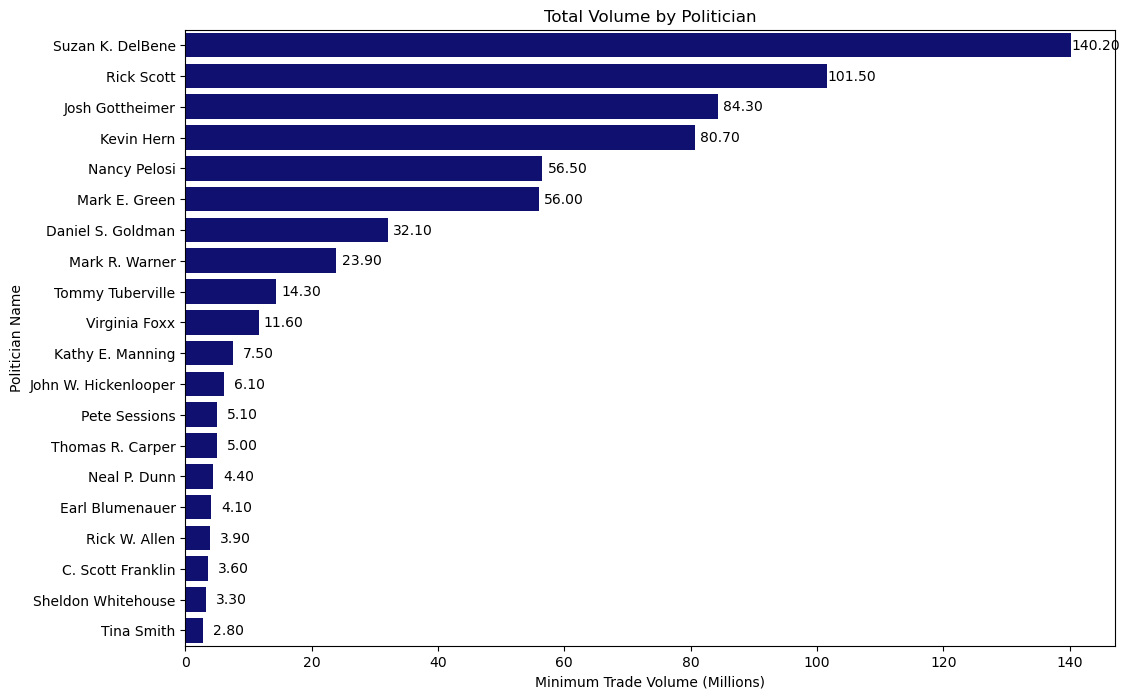

In [156]:
top_n = 20
plt.figure(figsize = (12,8))

senator_spend_agg['Volume (Millions)'] = round(senator_spend_agg['Volume'] / 1000000,1)

ax = sns.barplot(data = senator_spend_agg.head(top_n),  y = 'PoliticianName', x = 'Volume (Millions)', color = 'navy' )

for p in ax.patches:
    ax.annotate(f'{p.get_width():.2f}', (p.get_width()+4, p.get_y() + p.get_height() / 2), ha='center', va='center', fontsize=10, color='black')


plt.title('Total Volume by Politician')
plt.ylabel('Politician Name')
plt.xlabel('Minimum Trade Volume (Millions)')

plt.show()

Text(0.5, 0, 'Thousand Dollars Per Transaction')

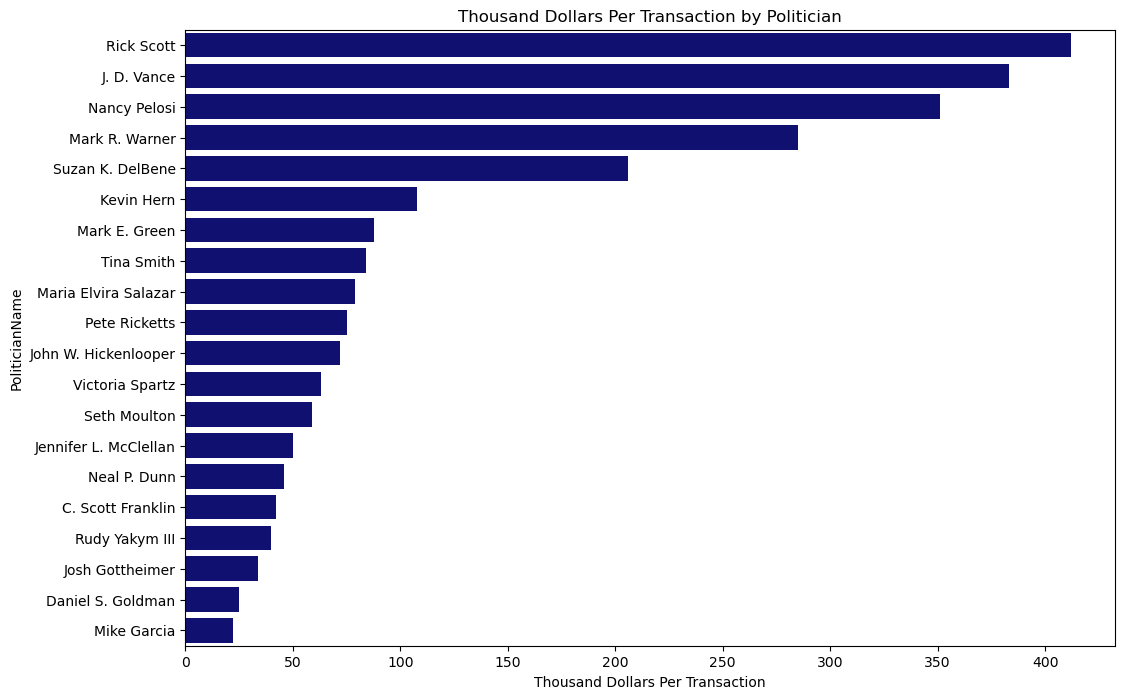

In [157]:
senator_spend_agg["Dollar_Per_Transaction"] = round((senator_spend_agg["Volume"]/senator_spend_agg['Transactions'])/1000,0)

senator_spend_agg_dpt = senator_spend_agg.sort_values(by = "Dollar_Per_Transaction", ascending = False)
plt.figure(figsize = (12,8))

a2 = sns.barplot(data = senator_spend_agg_dpt.head(top_n), y = "PoliticianName", x = "Dollar_Per_Transaction", color = 'navy') 
plt.title("Thousand Dollars Per Transaction by Politician")
plt.xlabel("Thousand Dollars Per Transaction")

In [158]:
senator_spend_yearly_agg = senator_spend_df.groupby(["PoliticianName", "Transaction_Year"]).agg(
    Volume = ("Min_TransactionAmount", "sum"),
    Transactions = ("Ticker", "count")
).sort_values(by = "Volume", ascending = False)

senator_spend_yearly_agg.reset_index(inplace = True)

Text(0.5, 0, 'Thousand Dollars Per Transaction')

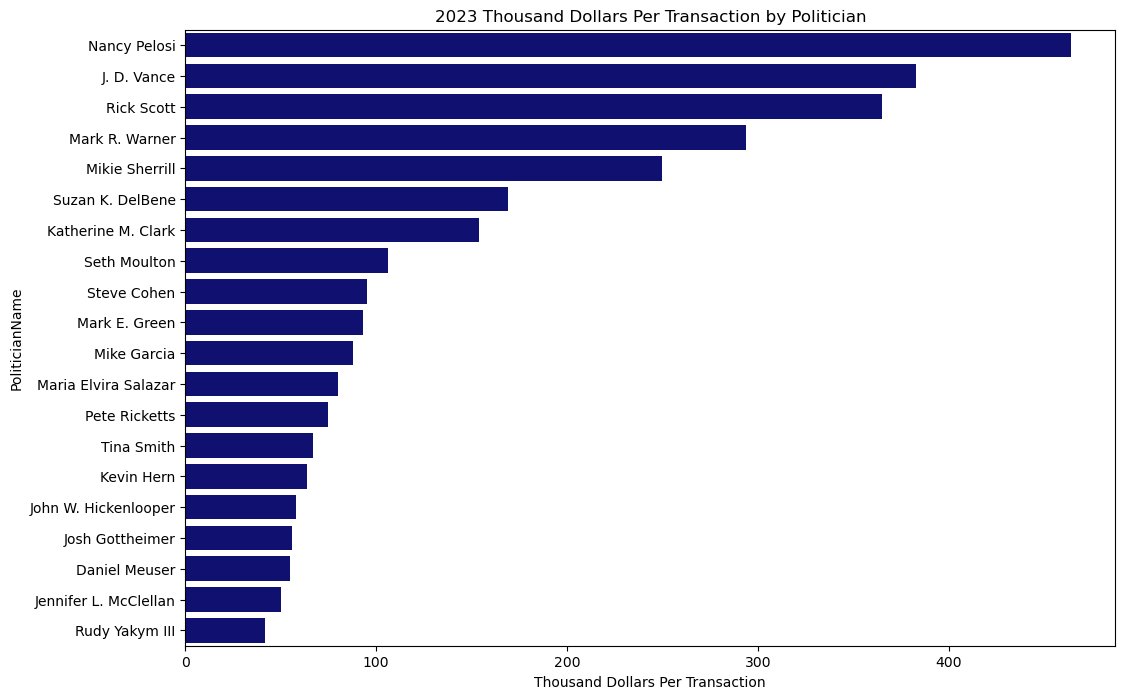

In [159]:
senator_spend_yearly_agg["Dollar_Per_Transaction"] = round((senator_spend_yearly_agg["Volume"]/senator_spend_yearly_agg['Transactions'])/1000,0)

senator_spend_yearly_agg_dpt = senator_spend_yearly_agg.sort_values(by = "Dollar_Per_Transaction", ascending = False)
plt.figure(figsize = (12,8))

a2 = sns.barplot(data = senator_spend_yearly_agg_dpt[senator_spend_yearly_agg_dpt["Transaction_Year"] == 2023].head(top_n), y = "PoliticianName", x = "Dollar_Per_Transaction", color = 'navy') 
plt.title("2023 Thousand Dollars Per Transaction by Politician")
plt.xlabel("Thousand Dollars Per Transaction")

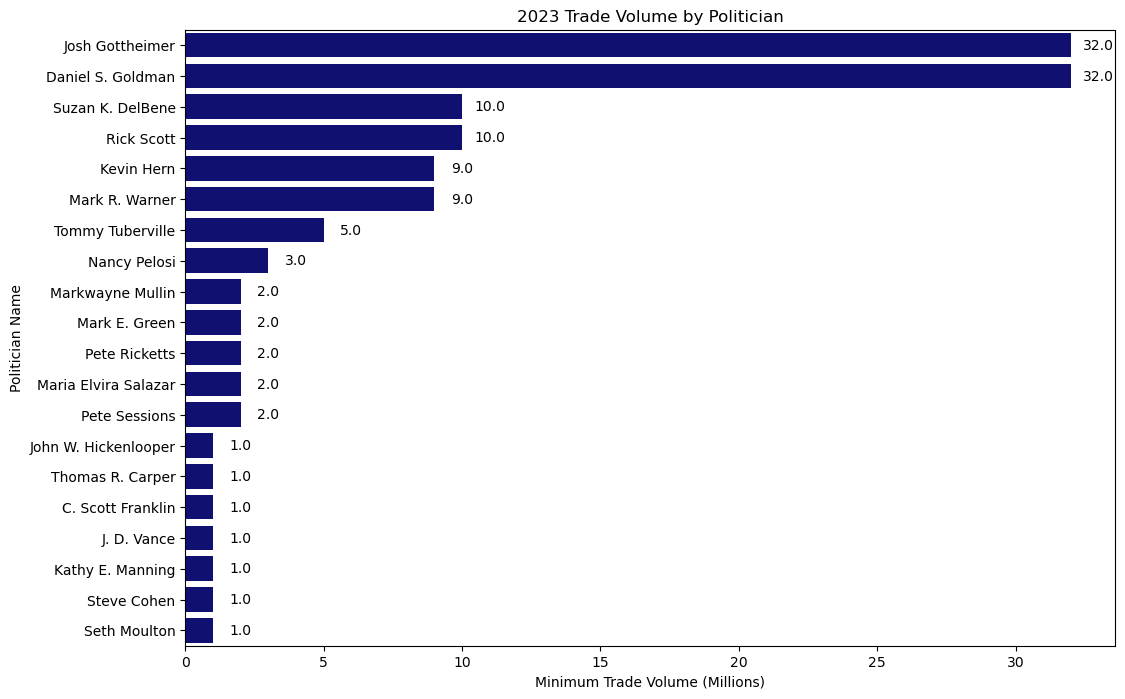

In [160]:
plt.figure(figsize = (12,8))

senator_spend_yearly_agg['Volume (Millions)'] = round(senator_spend_yearly_agg['Volume'] / 1000000,0)

senator_spend_yearly_agg.sort_values(by = 'Volume', ascending = False, inplace = True)

ax = sns.barplot(data = senator_spend_yearly_agg[senator_spend_yearly_agg["Transaction_Year"] == 2023].head(top_n),  y = 'PoliticianName', x = 'Volume (Millions)', color = 'navy' )

for p in ax.patches:
    ax.annotate(f'{p.get_width():.1f}', (p.get_width()+1, p.get_y() + p.get_height() / 2), ha='center', va='center', fontsize=10, color='black')


plt.title('2023 Trade Volume by Politician')
plt.ylabel('Politician Name')
plt.xlabel('Minimum Trade Volume (Millions)')

plt.show()

# Create Senator Activity Dataframe

In [202]:
df['Positive_Performance'] = (df['Performance'] > 0).astype(int)


df.head()

# all_time_senator_spend_agg = df.groupby(["PoliticianName"]).agg(
#     First_Trading_Year = ("Transaction_Year", "min"),
#     Active_Tradeing_Years = ("Transaction_Year", "nunique"),
#     Total_Trade_Volume = ("Min_TransactionAmount", "sum"),
#     Total_Transactions = ("Ticker", "count"),
#     Avg_Performance = ("Performance", "mean"),
#     Winning_Trades = ("Positive_Performance", "sum")
# )

# all_time_senator_spend_agg['Transaction_Year'] = 'All'
# all_time_senator_spend_agg['TransactionType'] = 'All'



all_time_senator_purchase_agg = df[df["TransactionType"] == "Purchase"].groupby(["PoliticianName"]).agg(
    First_Trading_Year = ("Transaction_Year", "min"),
    Active_Tradeing_Years = ("Transaction_Year", "nunique"),
    Total_Trade_Volume = ("Min_TransactionAmount", "sum"),
    Total_Transactions = ("Ticker", "count"),
    Avg_Performance = ("Performance", "mean"),
    Winning_Trades = ("Positive_Performance", "sum")


)
all_time_senator_purchase_agg['Transaction_Year'] = 'All'
all_time_senator_purchase_agg['TransactionType'] = 'Purchase'


# yrly_senator_spend_agg = df.groupby(["PoliticianName", "Transaction_Year"]).agg(
#     First_Trading_Year = ("Transaction_Year", "min"),
#     Active_Tradeing_Years = ("Transaction_Year", "nunique"),
#     Total_Trade_Volume = ("Min_TransactionAmount", "sum"),
#     Total_Transactions = ("Ticker", "count"),
#     Avg_Performance = ("Performance", "mean"),
#     Winning_Trades = ("Positive_Performance", "sum")

# )

# yrly_senator_spend_agg['TransactionType'] = 'All'


yrly_senator_purchase_agg = df[df["TransactionType"] == "Purchase"].groupby(["PoliticianName", "Transaction_Year"]).agg(
    First_Trading_Year = ("Transaction_Year", "min"),
    Active_Tradeing_Years = ("Transaction_Year", "nunique"),
    Total_Trade_Volume = ("Min_TransactionAmount", "sum"),
    Total_Transactions = ("Ticker", "count"),
    Avg_Performance = ("Performance", "mean"),
    Winning_Trades = ("Positive_Performance", "sum")
)

all_time_senator_purchase_agg['TransactionType'] = 'Purchase'

result = pd.concat([ all_time_senator_purchase_agg.reset_index(), yrly_senator_purchase_agg.reset_index()])

result["Percent_Winner"] = (result["Winning_Trades"] / result["Total_Transactions"]).round(4)
result.head()



# ranked_result = result.iloc[:,2:].rank(axis=0, method='min', ascending=False)
# ranked_result.columns = [col + '_Rank' for col in ranked_result.columns]

# senator_ranking = result.join(ranked_result, how = "left")

# senator_ranking.sort_values(by = 'Purchase_Performance_Rank').head()

# #senator_spend_agg.reset_index(inplace = True)

,PoliticianName,First_Trading_Year,Active_Tradeing_Years,Total_Trade_Volume,Total_Transactions,Avg_Performance,Winning_Trades,Transaction_Year,TransactionType,Percent_Winner
0,Abigail Davis Spanberger,2020,3,3003.00,3,-0.273300,0,All,Purchase,0.0000
1,Angus S. King Jr.,2014,9,251027.00,27,0.259711,3,All,Purchase,0.1111
2,Austin Scott,2013,4,142044.00,44,-0.483871,5,All,Purchase,0.1136
3,C. Scott Franklin,2022,2,422029.00,29,-0.021686,5,All,Purchase,0.1724
4,Carol D. Miller,2019,5,840121.35,63,-0.213077,12,All,Purchase,0.1905


In [203]:
print(str(result[(result["Avg_Performance"] > 0) & (result["Transaction_Year"] == "All")].shape[0]) + " Congressmen have outperformed the snp on average")


18 Congressmen have outperformed the snp on average


In [204]:
print(result["Avg_Performance"].round(2))

0     -0.27
1      0.26
2     -0.48
3     -0.02
4     -0.21
       ... 
350   -0.64
351     NaN
352    0.05
353   -0.10
354   -0.01
Name: Avg_Performance, Length: 424, dtype: float64


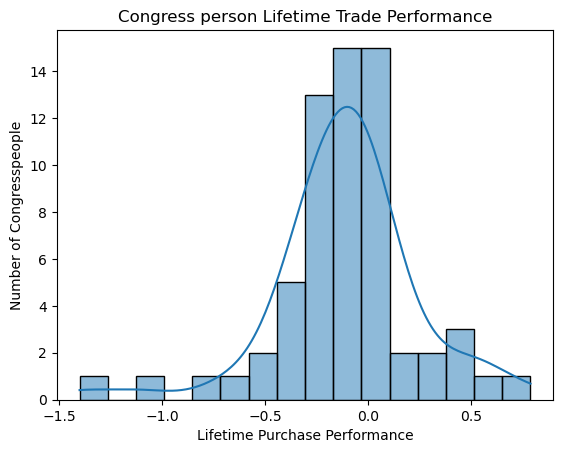

In [205]:
lifetime_perf_plt = result[result["Transaction_Year"] == "All"]["Avg_Performance"]

sns.histplot(lifetime_perf_plt, kde = True)
plt.title("Congress person Lifetime Trade Performance")
plt.xlabel("Lifetime Purchase Performance")
plt.ylabel("Number of Congresspeople")
plt.show()

# Takeaway
- Just that a senator makes a trade doesnt mean that it is a good tradeimport seaborn as sns
import matplotlib.pyplot as plt


# Takeaway

- More Trades, and more trade volume do not signifficantly interact wiht Performance

In [206]:
result[(result["Avg_Performance"] > 0) & (result["Transaction_Year"] == "All")]

,PoliticianName,First_Trading_Year,Active_Tradeing_Years,Total_Trade_Volume,Total_Transactions,Avg_Performance,Winning_Trades,Transaction_Year,TransactionType,Percent_Winner
1,Angus S. King Jr.,2014,9,251027.0,27,0.259711,3,All,Purchase,0.1111
5,Dan Crenshaw,2020,4,21021.0,21,0.091567,10,All,Purchase,0.4762
6,Dan Newhouse,2021,3,51051.0,51,0.095273,24,All,Purchase,0.4706
7,Dan Sullivan,2018,5,104041.0,41,0.503083,28,All,Purchase,0.6829
8,Daniel Meuser,2020,1,110026.0,26,0.059923,14,All,Purchase,0.5385
22,John R. Curtis,2019,5,272174.0,174,0.023840,57,All,Purchase,0.3276
25,Josh Gottheimer,2017,7,40924099.0,1099,0.075762,488,All,Purchase,0.4440
32,Mark E. Green,2020,4,27708477.0,477,0.502069,380,All,Purchase,0.7966
34,Markwayne Mullin,2017,2,2588139.0,139,0.016397,62,All,Purchase,0.4460
42,Morgan McGarvey,2023,1,3003.0,3,0.501100,3,All,Purchase,1.0000
